<a href="https://colab.research.google.com/github/ericburdett/cs601r-dl/blob/master/tl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning for Handwritten Documents

### Imports
Dependencies needed to run the code, including mounting GoogleDrive and copying files.

In [1]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader
assert torch.cuda.is_available(), "Request a GPU from Runtime > Change Runtime"

# Python
import gc
import os
import gzip
import tarfile
import time

# Data Structures
import pandas as pd
import numpy as np
import json
import csv

# Debug/Progress
from tqdm import tqdm
import pdb
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

# Image Manipulations / Plotting
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import cv2

# Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!cp "drive/My Drive/datasets/iam.zip" "/content"

In [33]:
!unzip -q iam.zip -d iam-word

warning [iam.zip]:  76 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [iam.zip]:  reported length of central directory is
  -76 bytes too long (Atari STZip zipfile?  J.H.Holm ZIPSPLIT 1.1
  zipfile?).  Compensating...
error:  expected central file header signature not found (file #95170).
  (please check that you have transferred or created the zipfile in the
  appropriate BINARY mode and that you have compiled UnZip properly)


In [0]:
!cp "drive/My Drive/datasets/iam-line-level.zip" "/content"
!cp "drive/My Drive/datasets/rimes-line-level.zip" "/content"
!unzip -q iam-line-level.zip -d iam
!unzip -q rimes-line-level.zip -d rimes
!rm iam-line-level.zip
!rm rimes-line-level.zip
!wget -q https://raw.githubusercontent.com/ericburdett/cs601r-dl/master/char_set.json

In [35]:
!ls iam-word

images	labels.csv


### Create IAM and RIMES Dataset Classes

In [0]:
class IamWordDataset(Dataset):
  def __init__(self, desired_size=(32, 128)):
    self.desired_size = desired_size
    self.img_path = '/content/iam-word/images/'
    self.df = pd.read_csv('/content/iam-word/labels.csv', header=None, sep='\t', names=['word', 'seg', 'transcription'], quoting=csv.QUOTE_NONE)

  def get_df(self):
    return self.df

  def tensor_image(self, path):
    img = Image.open(path + '.png')
    img = self.resize(img)
    # img = img.astype(np.float32)
    x = transforms.functional.to_tensor(img)

    return x

  def resize(self, img):
    img_size = np.array(img).shape

    img_ratio = img_size[0] / img_size[1]
    desired_ratio = self.desired_size[0] / self.desired_size[1]

    if img_ratio >= desired_ratio:
      # Solve by height
      new_height = self.desired_size[0]
      new_width = int(self.desired_size[0] // img_ratio)
    else:
      new_height = int(self.desired_size[1] * img_ratio)
      new_width = self.desired_size[1]
      # Solve by width

    img = np.array(img.resize((new_width, new_height)))

    border_top = self.desired_size[0] - new_height
    border_right = self.desired_size[1] - new_width

    img = np.pad(img, [(border_top, 0), (0, border_right)], mode='constant', constant_values=255)

    return img

  def __getitem__(self, index):
    path = 'iam-word/images/' + self.df['word'][index]
    img = self.tensor_image(path)

    return img, self.df['transcription'][index]

  def __len__(self):
    return len(self.df)

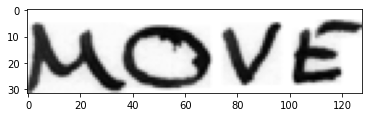

In [47]:
dataset = IamWordDataset()
plt.imshow(dataset[1][0].squeeze(), cmap='gray')

In [0]:
class IamDataset(Dataset):
  def __init__(self, desired_size=(32, 512)):
    self.desired_size = desired_size
    self.img_path = '/content/iam/images/'
    self.df = pd.read_csv('/content/iam/labels.csv', header=None, sep='\t', names=['img', 'transcription'], quoting=csv.QUOTE_NONE)

  def get_df(self):
    return self.df

  def tensor_image(self, path):
    img = Image.open(path + '.png')
    img = self.resize(img)
    # img = img.astype(np.float32)
    x = transforms.functional.to_tensor(img)

    return x

  def resize(self, img):
    img_size = np.array(img).shape

    img_ratio = img_size[0] / img_size[1]
    desired_ratio = self.desired_size[0] / self.desired_size[1]

    if img_ratio >= desired_ratio:
      # Solve by height
      new_height = self.desired_size[0]
      new_width = int(self.desired_size[0] // img_ratio)
    else:
      new_height = int(self.desired_size[1] * img_ratio)
      new_width = self.desired_size[1]
      # Solve by width

    img = np.array(img.resize((new_width, new_height)))

    border_top = self.desired_size[0] - new_height
    border_right = self.desired_size[1] - new_width

    img = np.pad(img, [(border_top, 0), (0, border_right)], mode='constant', constant_values=255)

    return img

  def __getitem__(self, index):
    path = 'iam/images/' + self.df['img'][index]
    img = self.tensor_image(path)

    return img, self.df['transcription'][index]

  def __len__(self):
    return len(self.df)

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])


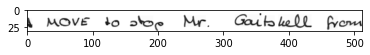

In [4]:
dataset = IamDataset()
print(dataset[0][0])
plt.imshow(dataset[0][0].squeeze(), cmap='gray')

In [0]:
class RimesDataset(Dataset):
  def __init__(self, desired_size=(32, 512)):
    self.desired_size = desired_size
    self.img_path = '/content/rimes/images/'
    self.df = pd.read_csv('/content/rimes/labels.csv', header=None, sep='\t', names=['img', 'transcription'], quoting=csv.QUOTE_NONE)

  def get_df(self):
    return self.df

  def tensor_image(self, path):
    img = Image.open(path)
    img = self.resize(img)
    img = img.astype(np.uint8)
    x = transforms.functional.to_tensor(img)

    return x

  def resize(self, img):
    img_size = np.array(img).shape

    img_ratio = img_size[0] / img_size[1]
    desired_ratio = self.desired_size[0] / self.desired_size[1]

    if img_ratio >= desired_ratio:
      # Solve by height
      new_height = self.desired_size[0]
      new_width = int(self.desired_size[0] // img_ratio)
    else:
      new_height = int(self.desired_size[1] * img_ratio)
      new_width = self.desired_size[1]
      # Solve by width

    img = np.array(img.resize((new_width, new_height)))

    border_top = self.desired_size[0] - new_height
    border_right = self.desired_size[1] - new_width

    img = np.pad(img, [(border_top, 0), (0, border_right)], mode='constant', constant_values=1)

    return img

  def __getitem__(self, index):
    path = 'rimes/images/' + self.df['img'][index]
    img = self.tensor_image(path)

    return img, str(self.df['transcription'][index])
  
  def __len__(self):
    return len(self.df)

tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]]])


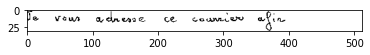

In [6]:
dataset = RimesDataset()
print(dataset[0][0])
plt.imshow(dataset[0][0].squeeze(), cmap='gray')

### Character Encoding

In [0]:
class Encoder():
  def __init__(self, sequence_size=150):
    with open('char_set.json') as file:
      self.json = json.load(file)
    
    self.sequence_size = sequence_size

  def remove_duplicates(self, idxs):
    new_idxs = []

    for i in range(len(idxs)):
      if i + 1 == len(idxs) or idxs[i] != idxs[i + 1]:
        new_idxs.append(idxs[i])
    
    return new_idxs
  
  def add_blanks(self, idxs):
    new_idxs = []

    for i in range(len(idxs)):
      new_idxs.append(idxs[i])
      if i + 1 != len(idxs) and idxs[i] == idxs[i + 1]:
        new_idxs.append(0)
    
    return new_idxs
  
  def idx_to_char(self, idx):
    if idx == 0:
      return ''
    else:
      return self.json['idx_to_char'][str(int(idx))]
  
  def char_to_idx(self, char):
    return int(self.json['char_to_idx'][char])
  
  def str_to_idxs(self, string):
    idxs = []

    zeros = np.zeros(self.sequence_size)

    for char in string:
      idxs.append(self.char_to_idx(char))

    # Add blanks if CTC-Loss requires it...
    # idxs = self.add_blanks(idxs)

    idxs = np.concatenate((idxs, zeros))[:self.sequence_size]
    
    return idxs, len(string)

  def idxs_to_str(self, idxs):
    string = ''
    idxs = self.remove_duplicates(idxs)

    for idx in idxs:
      string += self.idx_to_char(idx)
    
    return string
  
  def str_to_idxs_batch(self, batch):
    idxs = []
    lengths = []

    for string in batch:
      idx, length = self.str_to_idxs(string)
      idxs.append(idx)
      if length > self.sequence_size:
        length = self.sequence_size
      lengths.append(length)
    
    return idxs, lengths
  
  def idxs_to_str_batch(self, batch):
    strings = []

    for idxs in batch:
      strings.append(self.idxs_to_str(idxs))
    
    return strings

### Helper Functions

In [0]:
def show_imgs(x, new_fig=True):
    grid = utils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure(figsize=(50,100))
    plt.imshow(grid.numpy())

def parameter_count(model):
  return sum(p.numel() for p in model.parameters())

### Model

In [0]:
class RecognizerNew(nn.Module):
  def __init__(self, sequence_length=16, language_size=197, hidden_size=256, num_layers=2, dropout_rate=0.2, horizontal_dim=512):
    super(Recognizer, self).__init__()

    self.language_size = language_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.horizontal_dim = horizontal_dim

    # Encoder
    self.conv1 = nn.Sequential(nn.Conv2d(1, 8, 3, 1, 1), nn.LeakyReLU(), nn.BatchNorm2d(8))
    self.conv2 = nn.Sequential(nn.Conv2d(8, 16, 3, 1, 1), nn.LeakyReLU(), nn.BatchNorm2d(16))
    self.conv3 = nn.Sequential(nn.Conv2d(16, 32, 3, 1, 1), nn.LeakyReLU(), nn.BatchNorm2d(32))
    self.conv4 = nn.Sequential(nn.Conv2d(32, 64, 3, 1, 1), nn.LeakyReLU(), nn.BatchNorm2d(64))
    self.conv5 = nn.Sequential(nn.Conv2d(64, 128, 3, 1, 1), nn.LeakyReLU(), nn.BatchNorm2d(128))
    self.conv6 = nn.Sequential(nn.Conv2d(128, language_size, 3, 1, 1), nn.LeakyReLU(), nn.BatchNorm2d(language_size))

    self.gate1 = nn.Sequential(nn.Conv2d(8, 8, 3, 1, 1), nn.Sigmoid())
    self.gate2 = nn.Sequential(nn.Conv2d(16, 16, 3, 1, 1), nn.Sigmoid()) 
    self.gate3 = nn.Sequential(nn.Conv2d(32, 32, 3, 1, 1), nn.Sigmoid())
    self.gate4 = nn.Sequential(nn.Conv2d(64, 64, 3, 1, 1), nn.Sigmoid())
    self.gate5 = nn.Sequential(nn.Conv2d(128, 128, 3, 1, 1), nn.Sigmoid())

    self.drop1 = nn.Dropout2d(p=dropout_rate)
    self.drop2 = nn.Dropout2d(p=dropout_rate)
    self.drop3 = nn.Dropout2d(p=dropout_rate)
    self.drop4 = nn.Dropout2d(p=dropout_rate)
    self.drop5 = nn.Dropout2d(p=dropout_rate)

    # Maxpool
    self.mp = nn.MaxPool2d((32, 1))

    # Decoder
    self.gru1 = nn.GRU(self.horizontal_dim, self.hidden_size, self.num_layers, bidirectional=True, batch_first=True)
    self.fc1 = nn.Linear(self.hidden_size * 2, 128)
    self.gru2 = nn.GRU(128, self.hidden_size, self.num_layers, bidirectional=True, batch_first=True)
    self.fc2 = nn.Linear(self.hidden_size * 2, sequence_length)
    self.softmax = nn.LogSoftmax(dim=1)

  def init_hidden(self, batch_size):
    return torch.zeros(self.num_layers * 2, batch_size, self.hidden_size)

  def forward(self, x):
    # Encoder
    out = self.conv1(x)
    gate1 = self.gate1(out)
    out = out * gate1
    out = self.drop1(out)

    out = self.conv2(out)
    gate2 = self.gate2(out)
    out = out * gate2
    out = self.drop2(out)

    out = self.conv3(out)
    gate3 = self.gate3(out)
    out = out * gate3
    out = self.drop3(out)

    out = self.conv4(out)
    gate4 = self.gate4(out)
    out = out * gate4
    out = self.drop4(out)

    out = self.conv5(out)
    gate5 = self.gate5(out)
    out = out * gate5
    out = self.drop5(out)

    out = self.conv6(out)

    # Max Pooling across vertical dimension
    out = self.mp(out)

    # Decoder
    out = out.view(-1, self.language_size, self.horizontal_dim)

    out, _ = self.gru1(out)
    out = self.fc1(out)
    out, _ = self.gru2(out)
    out = self.fc2(out)
    out = self.softmax(out)

    # Change shape so that we can pass directly to CTC-Loss
    out = out.permute(2, 0, 1)

    return out

In [0]:
class Recognizer(nn.Module):
  def __init__(self, sequence_length=128, language_size=197, hidden_size=256, num_layers=1, dropout_rate=0.2, horizontal_dim=512, vertical_dim=32, activation=nn.ReLU):
    super(Recognizer, self).__init__()

    self.language_size = language_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.horizontal_dim = horizontal_dim

    # Encoder
    self.conv1 = nn.Sequential(nn.Conv2d(1, 8, 3, 1, 1), activation())
    self.conv2 = nn.Sequential(nn.Conv2d(8, 16, 3, 1, 1), activation())
    self.conv3 = nn.Sequential(nn.Conv2d(16, 32, 3, 1, 1), activation())
    self.conv4 = nn.Sequential(nn.Conv2d(32, 64, 3, 1, 1), activation())
    self.conv5 = nn.Sequential(nn.Conv2d(64, 128, 3, 1, 1), activation())
    self.conv6 = nn.Sequential(nn.Conv2d(128, self.language_size, 3, 1, 1), activation())


    self.gate1 = nn.Sequential(nn.Conv2d(16, 16, 3, 1, 1), nn.Sigmoid()) 
    self.gate2 = nn.Sequential(nn.Conv2d(32, 32, 3, 1, 1), nn.Sigmoid())
    self.gate3 = nn.Sequential(nn.Conv2d(64, 64, 3, 1, 1), nn.Sigmoid())
    self.gate4 = nn.Sequential(nn.Conv2d(128, 128, 3, 1, 1), nn.Sigmoid())

    # Maxpool
    self.mp = nn.MaxPool2d((vertical_dim, 1))

    # Decoder
    self.lstm1 = nn.LSTM(self.horizontal_dim, self.hidden_size, self.num_layers, bidirectional=True, batch_first=True)
    self.fc1 = nn.Sequential(nn.Linear(self.hidden_size * 2, 128),  activation())
    self.lstm2 = nn.LSTM(128, self.hidden_size, self.num_layers, bidirectional=True, batch_first=True)
    self.fc2 = nn.Linear(self.hidden_size * 2, sequence_length)
    self.softmax = nn.LogSoftmax(dim=1)

  def init_hidden(self, batch_size):
    return torch.zeros(self.num_layers * 2, batch_size, self.hidden_size)

  def forward(self, x):
    # Encoder
    out = self.conv1(x)

    out = self.conv2(out)
    gate1 = self.gate1(out)
    out = out * gate1

    out = self.conv3(out)
    gate2 = self.gate2(out)
    out = out * gate2

    out = self.conv4(out)
    gate3 = self.gate3(out)
    out = out * gate3

    out = self.conv5(out)
    gate4 = self.gate4(out)
    out = out * gate4

    out = self.conv6(out)

    # Max Pooling across vertical dimension
    out = self.mp(out)

    # Decoder
    out = out.view(-1, self.language_size, self.horizontal_dim)

    out, _ = self.lstm1(out)
    out = self.fc1(out)
    out, _ = self.lstm2(out)
    out = self.fc2(out)
    out = self.softmax(out)

    # Change shape so that we can pass directly to CTC-Loss
    out = out.permute(2, 0, 1)

    return out

In [0]:
class RecognizerOld(nn.Module):
  def __init__(self):
    super(RecognizerOld, self).__init__()

    self.hidden_size = 256
    self.num_layers = 1
    self.max_length = 20

    # Encoder
    self.conv1 = nn.Conv2d(1, 8, 3, 1, 1)
    self.tanh1 = nn.Tanh()
    self.conv2 = nn.Conv2d(8, 16, 3, 1, 1) # 4x2
    self.tanh2 = nn.Tanh()
    self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
    self.tanh3 = nn.Tanh()
    self.conv4 = nn.Conv2d(32, 64, 3, 1, 1) # 4x2
    self.tanh4 = nn.Tanh()
    self.conv5 = nn.Conv2d(64, 128, 3, 1, 1)
    self.tanh5 = nn.Tanh()

    self.gate1 = nn.Sequential(nn.Conv2d(16, 16, 3, 1, 1), nn.Sigmoid()) 
    self.gate2 = nn.Sequential(nn.Conv2d(32, 32, 3, 1, 1), nn.Sigmoid())
    self.gate3 = nn.Sequential(nn.Conv2d(64, 64, 3, 1, 1), nn.Sigmoid())

    # Maxpool
    self.mp = nn.MaxPool2d((32, 1))

    # Decoder
    self.gru1 = nn.GRU(128, self.hidden_size, self.num_layers, bidirectional=True, batch_first=True)
    self.fc1 = nn.Linear(self.hidden_size * 2, 128)
    self.gru2 = nn.GRU(128, self.hidden_size, self.num_layers, bidirectional=True, batch_first=True)
    self.fc2 = nn.Linear(self.hidden_size * 2, 16)
    self.softmax = nn.LogSoftmax(dim=1)

  def init_hidden(self, batch_size):
    return torch.zeros(self.num_layers * 2, batch_size, self.hidden_size)

  # Input -> (Batch, 1, 128, 256)
  def forward(self, x):
    # Encoder
    out = self.conv1(x)
    out = self.tanh1(out)
    out = self.conv2(out)
    out = self.tanh2(out)

    gate1 = self.gate1(out)
    out = out * gate1

    out = self.conv3(out)
    out = self.tanh3(out)

    gate2 = self.gate2(out)
    out = out * gate2

    out = self.conv4(out)
    out = self.tanh4(out)

    gate3 = self.gate3(out)
    out = out * gate3

    out = self.conv5(out)
    out = self.tanh5(out)

    # Max Pooling across vertical dimension
    out = self.mp(out)

    # Decoder
    out = out.view(-1, 128, 128)

    out, _ = self.gru1(out)
    out = self.fc1(out)
    out, _ = self.gru2(out)
    out = self.fc2(out)
    out = self.softmax(out)

    # Change shape so that we can pass directly to CTC-Loss
    out = out.permute(2, 0, 1)

    return out

In [122]:
r = RecognizerOld()
print(parameter_count(r))
r(torch.randn(1, 1, 32, 128)).shape

1406400


torch.Size([16, 1, 128])

In [121]:
rec = Recognizer(horizontal_dim=128)
print(parameter_count(rec))
rec(torch.randn(10, 1, 32, 128)).shape

2233845
torch.Size([10, 197, 32, 128])
torch.Size([10, 197, 1, 128])
torch.Size([10, 197, 128])
torch.Size([10, 197, 512])
torch.Size([10, 197, 128])


torch.Size([128, 10, 197])

In [124]:
recognizer = Recognizer(sequence_length=120)
print(parameter_count(recognizer))
recognizer(torch.randn(1, 1, 32, 512)).shape

3016173
torch.Size([1, 197, 32, 512])
torch.Size([1, 197, 1, 512])
torch.Size([1, 197, 512])
torch.Size([1, 197, 512])
torch.Size([1, 197, 128])


torch.Size([120, 1, 197])

### Model 2

In [0]:
class GatedConv2d(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1, activation=nn.ReLU):
    super(GatedConv2d, self).__init__()

    self.conv = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding), activation())
    self.gate = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding), nn.Sigmoid())
  
  def forward(self, x):
    out = self.conv(x)
    gate = self.gate(x)
    out = out * gate

    return out

In [0]:
class RecognizerFlor(nn.Module):
  def __init__(self, sequence_sizeactivation=nn.PReLU, h_dim=512):
    super(RecognizerFlor, self).__init__()

    self.h_dim = h_dim
    self.hidden_size = 256
    self.num_layers = 2

    self.conv1 = nn.Sequential(nn.Conv2d(1, 16, 3, 2, 1), activation(), nn.BatchNorm2d(16), GatedConv2d(16, 16, 3, 1, 1, activation))
    self.conv2 = nn.Sequential(nn.Conv2d(16, 32, (2, 4), (2, 4), 0), activation(), nn.BatchNorm2d(32), GatedConv2d(32, 32, 3, 1, 1, activation))
    self.conv3 = nn.Sequential(nn.Conv2d(32, 40, (2, 4), (2, 4), 0), activation(), nn.BatchNorm2d(40), GatedConv2d(40, 40, 3, 1, 1, activation), nn.Dropout2d(p=.2))
    self.conv4 = nn.Sequential(nn.Conv2d(40, 48, (2, 4), (2, 4), 0), activation(), nn.BatchNorm2d(48), GatedConv2d(48, 48, 3, 1, 1, activation), nn.Dropout2d(p=.2))
    self.conv5 = nn.Sequential(nn.Conv2d(48, 56, 3, 1, 1), activation(), nn.BatchNorm2d(56), GatedConv2d(56, 56, 3, 1, 1, activation), nn.Dropout2d(p=.2))
    self.conv6 = nn.Sequential(nn.Conv2d(56, 64, 3, 1, 1), activation(), nn.BatchNorm2d(64))

    self.lstm1 = nn.Sequential(nn.Dropout(p=.2), nn.LSTM(128, self.hidden_size, self.num_layers, bidirectional=True, batch_first=True))
    self.fc1 = nn.Linear(self.hidden_size * 2, 128)
    self.lstm2 = nn.Sequential(nn.Dropout(p=.2), nn.LSTM(128, self.hidden_size, self.num_layers, bidirectional=True, batch_first=True))
    self.fc2 = nn.Linear(self.hidden_size * 2, 128)

    self.cnn = nn.Sequential(self.conv1, self.conv2, self.conv3, self.conv4, self.conv5, self.conv6)
    self.mp = nn.MaxPool2d((2, 1))


  def forward(self, x):
    out = self.cnn(x)
    out = self.mp(out)

    out = out.view(-1, 64, self.h_dim // 128)
    
    return out

In [156]:
r = RecognizerFlor()
r(torch.randn(1, 1, 32, 512)).shape

torch.Size([1, 64, 4])

In [137]:
mp = nn.MaxPool2d((2, 1))
mp(torch.randn(10, 100, 32, 512)).shape

torch.Size([10, 100, 16, 512])

### IAM/Rimes Training

In [0]:
def train(dataset):
  EPOCHS = 150
  BATCH_SIZE = 32
  ITERATION_SAMPLE = 2000
  SEQUENCE_SIZE = 128

  train_dataset_size = int(.8 * len(dataset))
  val_dataset_size = len(dataset) - train_dataset_size
  train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_dataset_size, val_dataset_size])
  
  train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
  val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

  encoder = Encoder(sequence_size=SEQUENCE_SIZE)
  recognizer = Recognizer(sequence_length=SEQUENCE_SIZE, language_size=197, vertical_dim=dataset[0][0].shape[1], horizontal_dim=dataset[0][0].shape[2]).cuda()
  optimizer = optim.RMSprop(recognizer.parameters(), lr=4e-4)
  objective = nn.CTCLoss(blank=0, reduction='none', zero_infinity=True)

  train_losses_epochs = []
  val_losses_epochs = []

  for epoch in range(EPOCHS):
    loop = tqdm(total=len(train_loader), position=0, leave=True)

    train_losses = []
    val_losses = []

    # Training Loop
    # recognizer = recognizer.train()
    for batch_num, (imgs, words) in enumerate(train_loader):
      batch_size = imgs.shape[0]

      idxs, word_lengths = encoder.str_to_idxs_batch(words)

      imgs, labels = imgs.cuda(), torch.tensor(idxs).cuda()

      input_lengths = torch.full((batch_size,), SEQUENCE_SIZE, dtype=torch.long).cuda()
      target_lengths = torch.tensor(word_lengths).cuda()

      preds = recognizer(imgs)

      loss = objective(preds, labels, input_lengths, target_lengths)
      loss = torch.mean(loss)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

      if batch_num % ITERATION_SAMPLE == 0:
        preds_strings = encoder.idxs_to_str_batch(preds.permute(1, 0, 2).argmax(dim=2))
        print('\nTargets: ', words[:3])
        print('Predicted: ', preds_strings[:3])
        show_imgs(imgs[:3])
        plt.pause(1)

      loop.set_description('Train - Epoch: {}, Loss: {:.4f}, AvgLoss: {:.4f}'.format(epoch, loss.item(), np.mean(train_losses)))
      loop.update(1)
    
    loop.close()

    # # Validation Loop
    # recognizer = recognizer.eval()
    # val_loop = tqdm(total=len(val_loader), position=0, leave=True)
    # for batch_num, (imgs, words) in enumerate(val_loader):
    #   with torch.no_grad():
    #     batch_size = imgs.shape[0]

    #     idxs, word_lengths = encoder.str_to_idxs_batch(words)

    #     imgs, labels = imgs.cuda(), torch.tensor(idxs).cuda()

    #     optimizer.zero_grad()

    #     input_lengths = torch.full((batch_size,), SEQUENCE_SIZE, dtype=torch.long).cuda()
    #     target_lengths = torch.tensor(word_lengths).cuda()

    #     preds = recognizer(imgs)

    #     loss = objective(preds, labels, input_lengths, target_lengths)
    #     loss = torch.mean(loss)

    #     val_losses.append(loss.item())

    #     val_loop.set_description('Validation - Epoch: {}, Loss: {:.4f}, AvgLoss: {:.4f}'.format(epoch, loss.item(), np.mean(val_losses)))
    #     val_loop.update(1)

    # val_loop.close()

    train_losses_epochs.append(np.mean(train_losses))
    # val_losses_epochs.append(np.mean(val_losses))

  return recognizer, train_losses_epochs, val_losses_epochs

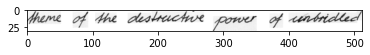

In [71]:
dataset = IamDataset(desired_size=(32, 512))
plt.imshow(dataset[3000][0].squeeze(), cmap='gray')

In [0]:
# Train with Iam Dataset
try:
  iam_dataset = IamDataset(desired_size=(32, 512))
  iam_recognizer, iam_train_losses, iam_val_losses = train(iam_dataset)
except:
  __ITB__()
  gc.collect()